In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
!pip install -c pytorch -c fastai fastai

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'


In [2]:
from fastai.vision import *

### Data

In [16]:
path = Path('D:\\DP\\Algae\\')

In [17]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="Train", valid ="Test",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [18]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Anabaena',
  'Arthrospira',
  'Ceratium',
  'Chlamydomonas',
  'Cyclidiopsis',
  'Desmodesmus',
  'Dunaliella',
  'Eudorina',
  'Glaucophyta',
  'Gymnodinium',
  'Kirchneriella',
  'Oonephris',
  'Oscillatoria',
  'Peridinium',
  'Phacus',
  'anisonema'],
 16,
 65001,
 16000)

In [19]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 65001
Number of examples in validation: 16000


In [20]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

---

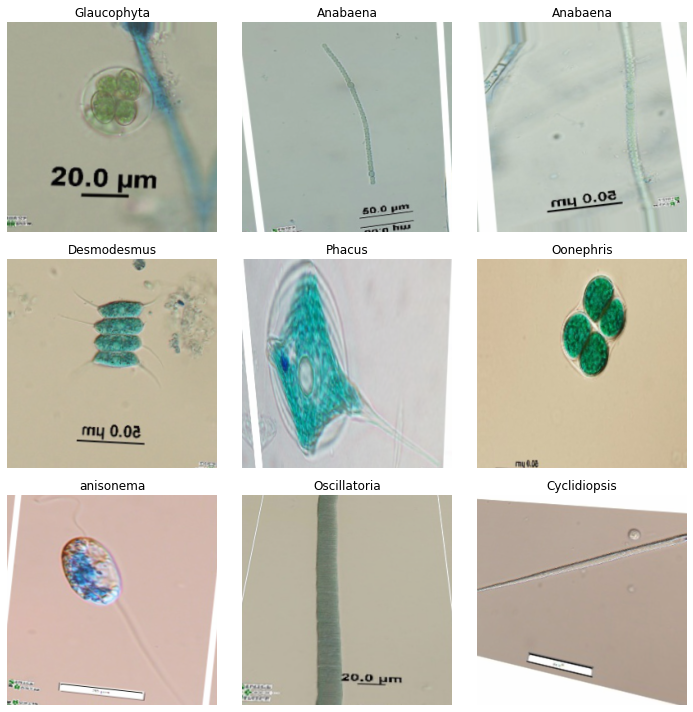

In [21]:
data.show_batch(rows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [25]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [26]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [27]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [28]:
import torch.nn as nn
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 16)
)

In [29]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [30]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [37]:
learn.fit_one_cycle(10, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [39]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

In [45]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
torch.cuda.available()

AttributeError: module 'torch.cuda' has no attribute 'available'

In [49]:
torch.backends.cudnn.enabled

True

In [51]:
torch.cuda.is_available()

False

In [32]:
learn.recorder.plot_losses()

AttributeError: 'Learner' object has no attribute 'recorder'

In [22]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 225


In [25]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [26]:
accuracy(probs,targets)

tensor(0.8933)

In [27]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 900, 225)

In [28]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

225 201 0.8933333333333333
[[ 24   1   3]
 [  0 102   7]
 [  1  12  75]]
              precision    recall  f1-score   support

    Covid-19       0.96      0.86      0.91        28
 No_findings       0.89      0.94      0.91       109
   Pneumonia       0.88      0.85      0.87        88

   micro avg       0.89      0.89      0.89       225
   macro avg       0.91      0.88      0.89       225
weighted avg       0.89      0.89      0.89       225



In [29]:
interp = ClassificationInterpretation.from_learner(learn)

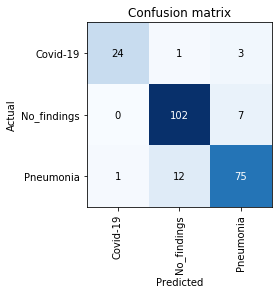

In [30]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);